# General notebook for testing purpose

Dashboard: https://developer.riotgames.com/  
Region endpoints: https://developer.riotgames.com/regional-endpoints.html  
Full reference: https://developer.riotgames.com/api-methods/

In [11]:
import requests
import pandas as pd

%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot")

## Functions

In [12]:
def get_json(url):
    return requests.get(url).json()

def get_summoner_data(region, summoner_name, api_key):
    url = 'https://{}.api.riotgames.com/lol/summoner/v3/summoners/by-name/{}?api_key={}'.format(
        region,
        summoner_name,
        api_key
    )
    return get_json(url)

def get_summoner_league(summoner_id, region, api_key):
    url = 'https://{}.api.riotgames.com/lol/league/v3/positions/by-summoner/{}?api_key={}'.format(
        region,
        summoner_id,
        api_key
    )
    return get_json(url)

## Parameters & API key

In [13]:
region = "euw1"
summoner_name = "Cyrlop"
api_key = "RGAPI-f9fbf09c-17b8-48e4-8cdb-ea6ef58a1057"
summoner_names = ["Cyrlop", "Helluin", "leag"]

In [14]:
# Test
get_summoner_data(region, summoner_name, api_key)

{u'accountId': 29238184,
 u'id': 24732627,
 u'name': u'Cyrlop',
 u'profileIconId': 3226,
 u'revisionDate': 1519938235000L,
 u'summonerLevel': 65}

## Summoners

In [15]:
json_summ_list = [get_summoner_data(region, summoner_name, api_key) for summoner_name in summoner_names]

In [16]:
df_summoners = pd.DataFrame(json_summ_list).set_index("name")
df_summoners

,accountId,id,profileIconId,revisionDate,summonerLevel
name,,,,,
Cyrlop,29238184,24732627,3226,1519938235000,65
Helluin,21603599,376152,19,1519932790000,60
leaG,239556,233829,661,1495764755000,30


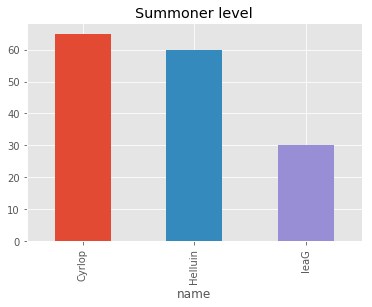

In [25]:
df_summoners["summonerLevel"].plot.bar(title="Summoner level")

## Leagues

In [18]:
json_league_list = [get_summoner_league(summoner_id, region, api_key) for summoner_id in df_summoners["id"]]

In [27]:
leagues = []
for l in json_league_list:
    for e in l:
        leagues.append(e)
df_leagues = pd.DataFrame(leagues).set_index(["playerOrTeamName","queueType"])
df_leagues["ratio"] = (df_leagues["wins"]/(df_leagues["losses"]+df_leagues["wins"]))*100
df_leagues["ratio"] = df_leagues["ratio"].apply(round, ndigits=2)
df_leagues

,,freshBlood,hotStreak,inactive,leagueId,leagueName,leaguePoints,losses,playerOrTeamId,rank,tier,veteran,wins,ratio
playerOrTeamName,queueType,,,,,,,,,,,,,
Cyrlop,RANKED_SOLO_5x5,False,False,False,98fcdbf0-fc9e-11e7-972b-c81f66dacb22,Zed's Spellswords,19,48,24732627,IV,GOLD,False,45,48.39
Helluin,RANKED_SOLO_5x5,False,False,False,adf0deb0-fa93-11e7-964f-c81f66dd0e0d,Trundle's Spellswords,46,74,376152,II,GOLD,True,71,48.97


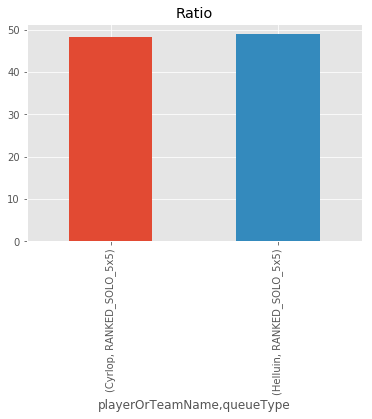

In [28]:
df_leagues["ratio"].plot.bar(title="Ratio")

In [112]:
df = pd.concat([df_summoners,df_leagues], axis=1, join="outer")
df

,accountId,id,profileIconId,revisionDate,summonerLevel,id
name,,,,,,
Cyrlop,29238184,24732627,3226,1519482189000,63,"[{u'queueType': u'RANKED_SOLO_5x5', u'hotStrea..."
Helluin,21603599,376152,19,1519469507000,56,"[{u'queueType': u'RANKED_SOLO_5x5', u'hotStrea..."
leaG,239556,233829,661,1495764755000,30,[]
